### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
#chaim edit 11/3/21 
from utils.writeToCSV import writeToCSV #importing to write results to CSV file
from utils.get_dates import get_start_date
from utils.get_dates import get_end_date

#from pathlib import Path
#import csv
%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
#User inputs 
while True:
    try:
        portfolio_value = input("To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': \n")
    
        if portfolio_value == 'Quit':
            print('You have quit the program. Have a nice day.')
            
            break
        
        portfolio_value = float(portfolio_value)
        
        if portfolio_value < 1000000:
            print("Unfortunately, you do not have enough savings to invest in a portfolio. \nThe minimum required is $1,000,000.")
    
        break
    except ValueError:
        print("Please only enter numerical digits.")

    



To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': 
 111111


Unfortunately, you do not have enough savings to invest in a portfolio. 
The minimum required is $1,000,000.


In [4]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    print("Thank you for your response!  You are a conversative investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    tickers = ["FB","AAPL","TSLA","RDS.A","GS"]
    print("Thank you for your response!  You are an aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Facebook, Apple, Tesla, Shell Oil, Goldman Sachs
elif int(risk_tolerance) == 3:
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    print("Thank you for your response!  You are a very aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")
#chaim edit- changed the print function to simplify output
risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string



    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  1


Thank you for your response!  You are a conversative investor.
The stocks in your portfolio will be ['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL']


In [5]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [6]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior business day 
# This will give you the closing price of the previous trading day
#Made it dynamic so start and end date are always T-1 business days 20211104
start_date = get_start_date() #pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = get_start_date() #pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
start_date

'2021-11-03T00:00:00-04:00'

In [7]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


BNDX                                  GOOGL  \
                           open   high    low  close   volume     open   
time                                                                     
2021-11-03 00:00:00-04:00  56.8  56.82  56.67  56.77  2120573  2918.89   

                                                               ...    PZA  \
                              high      low    close   volume  ...   open   
time                                                           ...          
2021-11-03 00:00:00-04:00  2933.38  2891.82  2931.95  1134323  ...  26.86   

                                                          VTEB               \
                            high    low   close  volume   open   high   low   
time                                                                          
2021-11-03 00:00:00-04:00  26.89  26.84  26.865  378081  54.61  54.66  54.6   

                                           
                           close   volume  
time                                       
2021-11-03 00:00:00-04:00  54.63  1230864  

[1 rows x 25 columns]

In [8]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

170.55

54.63

26.865

56.77

2931.95

In [9]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
value_per_share = portfolio_value/5 

#Paul Lopez added sample code for Bipasha to use when her dynamic weights- 20211103
#value_share1 = portfolio_value * weight1 'weight1 will be the weight as determined by Bipasha's algorithm
#value_share2 = portfolio_value * weight2
#value_share3 = portfolio_value * weight3
#value_share4 = portfolio_value * weight4
#value_share5 = portfolio_value * weight5


stock1_shares = value_per_share / stock1_close_price
stock2_shares = value_per_share / stock2_close_price
stock3_shares = value_per_share / stock3_close_price
stock4_shares = value_per_share / stock4_close_price
stock5_shares = value_per_share / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With ${value_per_share:.2f} you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


With $22222.20 you will be able to purchase 130 shares of JPM.
With $22222.20 you will be able to purchase 407 shares of VTEB.
With $22222.20 you will be able to purchase 827 shares of PZA.
With $22222.20 you will be able to purchase 391 shares of BNDX.
With $22222.20 you will be able to purchase 8 shares of GOOGL.


In [10]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
#Added dynamic start and end date 20211104 Paul Lopez
start_date = get_end_date() #pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = get_start_date() #pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

display(start_date)
display(end_date)
limit_rows = 1000

'2011-09-08T00:00:00-04:00'

'2021-11-03T00:00:00-04:00'

In [11]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

BNDX                                    GOOGL  \
                            open  high      low  close    volume     open   
time                                                                        
2017-11-13 00:00:00-05:00  54.88  54.9  54.8200  54.82  410429.0      NaN   
2017-11-14 00:00:00-05:00  54.86  54.9  54.8372  54.87  500416.0  1037.72   

                                                               ...    PZA  \
                             high      low    close    volume  ...   open   
time                                                           ...          
2017-11-13 00:00:00-05:00     NaN      NaN      NaN       NaN  ...    NaN   
2017-11-14 00:00:00-05:00  1042.3  1029.33  1041.69  523989.0  ...  25.68   

                                                             VTEB          \
                            high      low  close    volume   open    high   
time                                                                        
2017-11-13 00:00:00-05:00    NaN      NaN    NaN       NaN  51.72  51.720   
2017-11-14 00:00:00-05:00  25.68  25.6475  25.67  247174.0  51.66  51.692   

                                                    
                             low   close    volume  
time                                                
2017-11-13 00:00:00-05:00  51.66  51.695  229993.0  
2017-11-14 00:00:00-05:00  51.65  51.690  195251.0  

[2 rows x 25 columns]

BNDX                                     GOOGL  \
                            open   high    low   close     volume     open   
time                                                                         
2021-11-02 00:00:00-04:00  56.74  56.84  56.74  56.825  2291789.0  2890.99   
2021-11-03 00:00:00-04:00  56.80  56.82  56.67  56.770  2120573.0  2918.89   

                                                                 ...    PZA  \
                              high      low    close     volume  ...   open   
time                                                             ...          
2021-11-02 00:00:00-04:00  2932.18  2886.71  2908.29  1456693.0  ...  26.81   
2021-11-03 00:00:00-04:00  2933.38  2891.82  2931.95  1134323.0  ...  26.86   

                                                            VTEB         \
                            high    low   close    volume   open   high   
time                                                                      
2021-11-02 00:00:00-04:00  26.84  26.79  26.810  144755.0  54.57  54.62   
2021-11-03 00:00:00-04:00  26.89  26.84  26.865  378081.0  54.61  54.66   

                                                    
                             low  close     volume  
time                                                
2021-11-02 00:00:00-04:00  54.57  54.60  1327638.0  
2021-11-03 00:00:00-04:00  54.60  54.63  1230864.0  

[2 rows x 25 columns]

['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL']

###Here we run a Monte Carlo simulation of 1000 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [12]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input.

#Changed 2021-11-02. We will run 3 scenarios of 5yr, 10yr, and 20yr.
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
MC_even_weight_5yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*5 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 5 now
)

# Review the simulation input data
MC_even_weight_5yr.portfolio_data.head()


BNDX                                   \
                            open   high      low  close    volume   
time                                                                
2017-11-13 00:00:00-05:00  54.88  54.90  54.8200  54.82  410429.0   
2017-11-14 00:00:00-05:00  54.86  54.90  54.8372  54.87  500416.0   
2017-11-15 00:00:00-05:00  54.95  54.98  54.9000  54.96  700230.0   
2017-11-16 00:00:00-05:00  54.94  54.96  54.9400  54.96  525708.0   
2017-11-17 00:00:00-05:00  54.98  54.99  54.9300  54.95  493074.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-13 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-14 00:00:00-05:00     0.000912  1037.72  1042.30  1029.33  1041.69   
2017-11-15 00:00:00-05:00     0.001640  1035.00  1039.63  1030.76  1036.62   
2017-11-16 00:00:00-05:00     0.000000  1038.75  1051.76  1038.00  1048.47   
2017-11-17 00:00:00-05:00    -0.000182  1050.95  1051.00  1033.73  1035.67   

                           ...      PZA                                 VTEB  \
                           ...      low  close    volume daily_return   open   
time                       ...                                                 
2017-11-13 00:00:00-05:00  ...      NaN    NaN       NaN          NaN  51.72   
2017-11-14 00:00:00-05:00  ...  25.6475  25.67  247174.0          NaN  51.66   
2017-11-15 00:00:00-05:00  ...  25.6500  25.72  265598.0     0.001948  51.74   
2017-11-16 00:00:00-05:00  ...  25.6700  25.69  253833.0    -0.001166  51.73   
2017-11-17 00:00:00-05:00  ...  25.6500  25.67  170742.0    -0.000779  51.64   

                                                                          
                             high     low   close    volume daily_return  
time                                                                      
2017-11-13 00:00:00-05:00  51.720  51.660  51.695  229993.0          NaN  
2017-11-14 00:00:00-05:00  51.692  51.650  51.690  195251.0    -0.000097  
2017-11-15 00:00:00-05:00  51.740  51.663  51.700  282145.0     0.000193  
2017-11-16 00:00:00-05:00  51.730  51.660  51.680  319540.0    -0.000387  
2017-11-17 00:00:00-05:00  51.670  51.610  51.640  204256.0    -0.000774  

[5 rows x 30 columns]

In [13]:
MC_even_weight_10yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*10 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 10 now
)

MC_even_weight_10yr.portfolio_data.head()

BNDX                                   \
                            open   high      low  close    volume   
time                                                                
2017-11-13 00:00:00-05:00  54.88  54.90  54.8200  54.82  410429.0   
2017-11-14 00:00:00-05:00  54.86  54.90  54.8372  54.87  500416.0   
2017-11-15 00:00:00-05:00  54.95  54.98  54.9000  54.96  700230.0   
2017-11-16 00:00:00-05:00  54.94  54.96  54.9400  54.96  525708.0   
2017-11-17 00:00:00-05:00  54.98  54.99  54.9300  54.95  493074.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-13 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-14 00:00:00-05:00     0.000912  1037.72  1042.30  1029.33  1041.69   
2017-11-15 00:00:00-05:00     0.001640  1035.00  1039.63  1030.76  1036.62   
2017-11-16 00:00:00-05:00     0.000000  1038.75  1051.76  1038.00  1048.47   
2017-11-17 00:00:00-05:00    -0.000182  1050.95  1051.00  1033.73  1035.67   

                           ...      PZA                                 VTEB  \
                           ...      low  close    volume daily_return   open   
time                       ...                                                 
2017-11-13 00:00:00-05:00  ...      NaN    NaN       NaN          NaN  51.72   
2017-11-14 00:00:00-05:00  ...  25.6475  25.67  247174.0          NaN  51.66   
2017-11-15 00:00:00-05:00  ...  25.6500  25.72  265598.0     0.001948  51.74   
2017-11-16 00:00:00-05:00  ...  25.6700  25.69  253833.0    -0.001166  51.73   
2017-11-17 00:00:00-05:00  ...  25.6500  25.67  170742.0    -0.000779  51.64   

                                                                          
                             high     low   close    volume daily_return  
time                                                                      
2017-11-13 00:00:00-05:00  51.720  51.660  51.695  229993.0          NaN  
2017-11-14 00:00:00-05:00  51.692  51.650  51.690  195251.0    -0.000097  
2017-11-15 00:00:00-05:00  51.740  51.663  51.700  282145.0     0.000193  
2017-11-16 00:00:00-05:00  51.730  51.660  51.680  319540.0    -0.000387  
2017-11-17 00:00:00-05:00  51.670  51.610  51.640  204256.0    -0.000774  

[5 rows x 30 columns]

In [14]:
MC_even_weight_20yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*20 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 20 now
)
MC_even_weight_20yr.portfolio_data.head()

BNDX                                   \
                            open   high      low  close    volume   
time                                                                
2017-11-13 00:00:00-05:00  54.88  54.90  54.8200  54.82  410429.0   
2017-11-14 00:00:00-05:00  54.86  54.90  54.8372  54.87  500416.0   
2017-11-15 00:00:00-05:00  54.95  54.98  54.9000  54.96  700230.0   
2017-11-16 00:00:00-05:00  54.94  54.96  54.9400  54.96  525708.0   
2017-11-17 00:00:00-05:00  54.98  54.99  54.9300  54.95  493074.0   

                                          GOOGL                             \
                          daily_return     open     high      low    close   
time                                                                         
2017-11-13 00:00:00-05:00          NaN      NaN      NaN      NaN      NaN   
2017-11-14 00:00:00-05:00     0.000912  1037.72  1042.30  1029.33  1041.69   
2017-11-15 00:00:00-05:00     0.001640  1035.00  1039.63  1030.76  1036.62   
2017-11-16 00:00:00-05:00     0.000000  1038.75  1051.76  1038.00  1048.47   
2017-11-17 00:00:00-05:00    -0.000182  1050.95  1051.00  1033.73  1035.67   

                           ...      PZA                                 VTEB  \
                           ...      low  close    volume daily_return   open   
time                       ...                                                 
2017-11-13 00:00:00-05:00  ...      NaN    NaN       NaN          NaN  51.72   
2017-11-14 00:00:00-05:00  ...  25.6475  25.67  247174.0          NaN  51.66   
2017-11-15 00:00:00-05:00  ...  25.6500  25.72  265598.0     0.001948  51.74   
2017-11-16 00:00:00-05:00  ...  25.6700  25.69  253833.0    -0.001166  51.73   
2017-11-17 00:00:00-05:00  ...  25.6500  25.67  170742.0    -0.000779  51.64   

                                                                          
                             high     low   close    volume daily_return  
time                                                                      
2017-11-13 00:00:00-05:00  51.720  51.660  51.695  229993.0          NaN  
2017-11-14 00:00:00-05:00  51.692  51.650  51.690  195251.0    -0.000097  
2017-11-15 00:00:00-05:00  51.740  51.663  51.700  282145.0     0.000193  
2017-11-16 00:00:00-05:00  51.730  51.660  51.680  319540.0    -0.000387  
2017-11-17 00:00:00-05:00  51.670  51.610  51.640  204256.0    -0.000774  

[5 rows x 30 columns]

In [15]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
#Changed on 2021-11-02 by Paul Lopez. Will now be running 5yr, 10yr, and 20yr MC scenarios.
MC_even_weight_5yr.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009959,0.997813,1.001922,0.997340,1.002910,1.011935,1.017611,0.993893,1.003400,0.998241,...,1.000358,0.999690,1.002595,0.999042,1.009708,0.986392,0.990440,0.994355,1.010094,0.993911
2,1.004125,0.991519,0.996915,1.006184,0.991694,1.017784,1.021263,0.994690,0.990984,0.994084,...,0.991444,1.006087,0.993347,0.999797,1.004747,0.977869,0.985945,0.990976,1.009391,0.988071
3,1.002042,0.995270,0.984199,0.997327,0.993245,1.029955,1.022998,0.993625,0.990257,1.001834,...,0.989498,1.001151,0.998875,1.004190,0.998726,0.993445,0.983615,0.987972,1.003485,0.987784
4,1.003840,1.004262,0.984749,1.006198,0.999811,1.036229,1.018178,0.997048,0.991632,0.999404,...,0.995924,0.998477,0.989493,1.009023,1.001083,1.000281,0.991019,0.995442,1.009862,0.996147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.693430,1.493857,1.530455,1.751067,1.323784,1.446866,2.015805,1.529665,1.617202,1.706920,...,1.703354,1.754212,1.986215,1.312583,1.482498,1.759191,2.750431,1.404882,2.605446,1.670744
1257,1.677646,1.494468,1.553775,1.771620,1.328942,1.443154,2.029920,1.525491,1.620677,1.708517,...,1.698001,1.742722,1.998442,1.303093,1.493201,1.756345,2.756179,1.407780,2.630972,1.684106
1258,1.669100,1.500505,1.572367,1.790678,1.343441,1.435017,2.012989,1.521174,1.626621,1.713198,...,1.681956,1.756535,1.993553,1.287740,1.495412,1.737598,2.768166,1.421494,2.614482,1.697425
1259,1.663425,1.498544,1.564525,1.795804,1.353986,1.438078,2.010567,1.513921,1.627992,1.725051,...,1.678157,1.749848,2.002807,1.299493,1.494899,1.729637,2.770885,1.423893,2.613545,1.693460


In [16]:
MC_even_weight_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993725,1.005569,1.006445,1.000100,1.004947,0.992108,0.999263,0.993917,1.000290,1.010158,...,1.002418,1.000374,1.000014,1.005608,1.003595,0.995621,0.990064,1.007095,1.004317,1.002214
2,0.993042,1.002434,1.007144,1.003975,1.011563,0.992873,1.003460,0.986790,0.992054,1.013719,...,1.001318,0.996393,1.007129,1.023211,1.002061,0.995671,0.990902,1.013460,1.000509,1.003166
3,0.998864,0.998054,1.007495,1.006717,1.006683,0.993652,1.005475,0.987131,1.002385,1.021290,...,1.008563,0.999768,1.007007,1.032617,1.009349,0.993026,0.985940,1.015778,0.996423,1.004598
4,1.007115,1.006860,1.009412,1.011542,1.008009,0.992568,1.017470,0.982745,1.005951,1.013028,...,1.018518,0.991097,1.008656,1.034549,1.013560,0.994236,0.990415,1.022453,0.995208,1.004747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.040240,2.287883,2.815199,2.752405,3.950842,2.680245,4.157716,2.848656,2.831720,2.934844,...,3.593662,3.263312,2.795041,2.124297,3.950514,1.662839,3.108378,3.743945,3.627287,3.200415
2517,2.054823,2.266029,2.805621,2.749810,3.970527,2.682913,4.194983,2.845523,2.810808,2.936396,...,3.620307,3.265649,2.766518,2.131092,3.948214,1.671316,3.104912,3.726487,3.588656,3.185713
2518,2.051992,2.280219,2.789572,2.764359,3.969106,2.686225,4.238232,2.824067,2.813496,2.923296,...,3.631034,3.270538,2.736171,2.129586,3.938259,1.681537,3.139580,3.697080,3.623969,3.185830
2519,2.033057,2.258778,2.806402,2.754536,3.983890,2.693275,4.253882,2.819808,2.800103,2.891446,...,3.645614,3.287924,2.716250,2.130604,3.954086,1.676857,3.133937,3.710744,3.611185,3.190240


In [17]:
MC_even_weight_20yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009374,0.994359,0.986949,0.997984,0.998427,1.005308,1.005321,1.006324,1.000151,0.996228,...,1.007216,0.997332,0.991081,1.009078,1.006300,0.990077,1.001050,1.005123,1.001692,0.995916
2,1.006544,0.996593,0.998062,1.004915,0.991333,0.998157,0.993414,1.003214,1.004778,0.991255,...,1.012817,0.997242,0.987976,1.009219,1.015580,0.979503,1.002867,1.000791,0.997453,1.005198
3,1.009197,1.005256,0.995649,1.001390,0.985464,0.997930,0.995529,1.001786,1.006782,0.991448,...,1.017802,0.993251,0.972884,1.013964,1.022398,0.982087,1.014723,0.996326,0.999269,1.002217
4,1.018694,1.001340,1.003294,1.003863,0.990917,1.001632,0.997116,0.988847,1.012530,0.990277,...,1.018512,0.982575,0.962183,1.015810,1.031880,0.978709,1.014211,0.997562,0.999405,1.013070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,9.738404,10.781206,9.538546,7.045104,5.910161,10.015350,10.315849,10.807735,12.589560,12.545599,...,5.388112,12.617070,10.952625,6.574146,13.349554,5.690313,14.121987,8.632203,7.217328,5.581199
5037,9.823261,10.674039,9.518585,7.014109,5.898041,10.019990,10.302376,10.879789,12.489436,12.671907,...,5.354698,12.736366,10.873740,6.517085,13.471340,5.715274,14.116804,8.613071,7.276669,5.581514
5038,9.817486,10.764341,9.601600,7.027426,5.876887,10.014151,10.250038,10.855824,12.422683,12.698053,...,5.318751,12.680378,10.817649,6.455329,13.393186,5.702002,14.028621,8.619789,7.305775,5.601357
5039,9.724632,10.675104,9.681399,7.055772,5.917184,9.996413,10.198814,10.877558,12.380896,12.676996,...,5.370483,12.623467,10.715148,6.445313,13.432617,5.664668,13.965801,8.636607,7.341817,5.630229


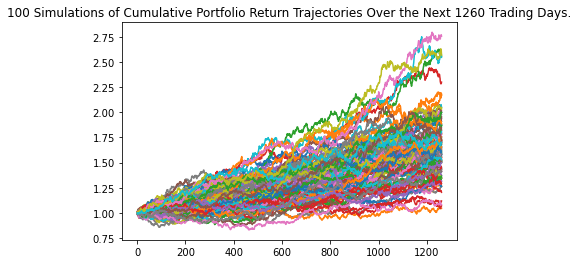

In [18]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 5yr scenario
MC_even_weight_line_5yr_plot = MC_even_weight_5yr.plot_simulation()


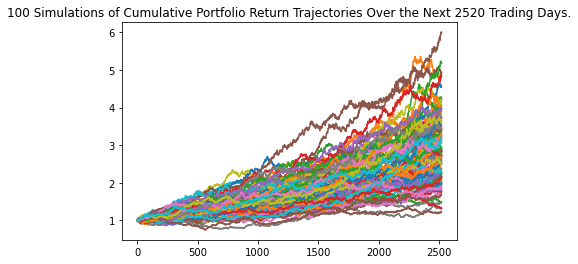

In [19]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 10yr scenario

MC_even_weight_line_10yr_plot = MC_even_weight_10yr.plot_simulation()

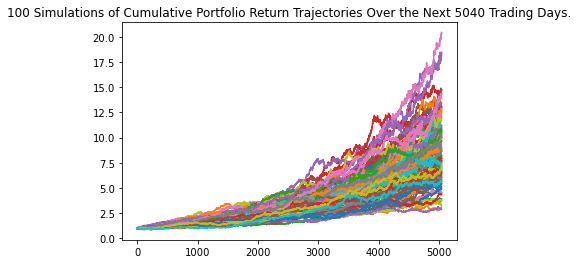

In [20]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 20yr scenario

MC_even_weight_line_20yr_plot = MC_even_weight_20yr.plot_simulation()

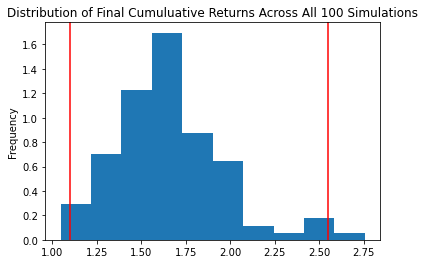

In [21]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
#Changed on 2021-11-02 by Paul Lopez. We are now plotting for all 3 time horizons of 5yr, 10yr, and 20yr.
MC_even_weight_5yr_distibution_plot = MC_even_weight_5yr.plot_distribution()


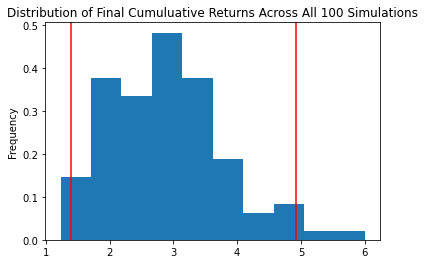

In [22]:
MC_even_weight_10yr_distibution_plot = MC_even_weight_10yr.plot_distribution()


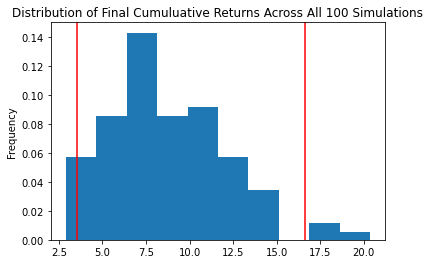

In [23]:
MC_even_weight_20yr_distibution_plot = MC_even_weight_20yr.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [24]:
# Generate summary statistics from the Monte Carlo simulation 5yr results
# We save the results as a variable
MC_even_weight_5yr_summary_table = MC_even_weight_5yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_5yr_summary_table)

count           100.000000
mean              1.670848
std               0.315829
min               1.046379
25%               1.499861
50%               1.655648
75%               1.814539
max               2.756302
95% CI Lower      1.100277
95% CI Upper      2.551807
Name: 1260, dtype: float64


In [25]:
# Generate summary statistics from the Monte Carlo simulation 10yr results
# We save the results as a variable
MC_even_weight_10yr_summary_table = MC_even_weight_10yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_10yr_summary_table)

count           100.000000
mean              2.877140
std               0.908923
min               1.229068
25%               2.219625
50%               2.818334
75%               3.404880
max               6.002168
95% CI Lower      1.394425
95% CI Upper      4.928428
Name: 2520, dtype: float64


In [26]:
# Generate summary statistics from the Monte Carlo simulation 20yr results
# We save the results as a variable
MC_even_weight_20yr_summary_table = MC_even_weight_20yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_20yr_summary_table)

count           100.000000
mean              8.710043
std               3.415206
min               2.892771
25%               6.354182
50%               8.062173
75%              10.696122
max              20.369160
95% CI Lower      3.515836
95% CI Upper     16.602209
Name: 5040, dtype: float64


In [27]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 5 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_5yr} and ${ci_upper_thirty_cumulative_return_5yr}.")


There is a 95% chance that the current value of $111111.00 in the portfolio with an even 20% weight in each stock over the next 5 years will end within the range of $122252.93 and $283533.8.


In [28]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 10 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_10yr} and ${ci_upper_thirty_cumulative_return_10yr}.")


There is a 95% chance that the current value of $111111.00 in the portfolio with an even 20% weight in each stock over the next 10 years will end within the range of $154935.93 and $547602.6.


In [29]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 20 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_20yr} and ${ci_upper_thirty_cumulative_return_20yr}.")


There is a 95% chance that the current value of $111111.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $390648.01 and $1844688.1.


In [30]:
#created dictionary to store values for csv file
#client_info_dict = {
    #"Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-"],
    #"Value Per Share" : [f"${value_per_share:.2f}", f"${value_per_share:.2f}", f"${value_per_share:.2f}",
     #                    f"${value_per_share:.2f}", f"${value_per_share:.2f}"],
    #"Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4]],
    #"Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}", f"{stock4_shares:.0f}", f"{stock5_shares:.0f}"]    }  
#print(client_info_dict)

{'Value of Portfolio': ['$111111.00', '-', '-', '-', '-'], 'Value Per Share': ['$22222.20', '$22222.20', '$22222.20', '$22222.20', '$22222.20'], 'Portfolio Tickers': ['JPM', 'VTEB', 'PZA', 'BNDX', 'GOOGL'], 'Shares per Ticker': ['130', '407', '827', '391', '8']}


In [31]:
#created dataframe from dictionary
#client_info_df = pd.DataFrame(client_info_dict)
#client_info_df.set_index("Value of Portfolio")

,Value Per Share,Portfolio Tickers,Shares per Ticker
Value of Portfolio,,,
$111111.00,$22222.20,JPM,130
-,$22222.20,VTEB,407
-,$22222.20,PZA,827
-,$22222.20,BNDX,391
-,$22222.20,GOOGL,8


In [32]:
#created csv with dataframe
#client_info_df.to_csv("Client Info.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [33]:
#created dictionary to turn into a csv file
#report_details_dict = {
 #   "Holding Period" : ["5year", "10year", "20year"],
  #  "Lower Bound Values" : [f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
   #                f"${ci_lower_thirty_cumulative_return_20yr}"],
    #"Upper Bound Values" : [f"${ci_upper_thirty_cumulative_return_5yr}",f"${ci_upper_thirty_cumulative_return_10yr}",
     #              F"${ci_upper_thirty_cumulative_return_20yr}"]}
                 

In [34]:
#created dataframe with dictionary
#report_details_df = pd.DataFrame(report_details_dict)
#report_details_df.set_index("Holding Period")

,Lower Bound Values,Upper Bound Values
Holding Period,,
5year,$122252.93,$283533.8
10year,$154935.93,$547602.6
20year,$390648.01,$1844688.1


In [35]:
# created csv file with dataframe
#report_details_df.to_csv("Report Details.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [36]:
#joining the dataframes together for the final report.
#joined_dataframes = pd.concat([client_info_df, report_details_df], axis=1)
#reviewing the joined dataframes to check for NAN's.
#joined_dataframes

,Value of Portfolio,Value Per Share,Portfolio Tickers,Shares per Ticker,Holding Period,Lower Bound Values,Upper Bound Values
0,$111111.00,$22222.20,JPM,130,5year,$122252.93,$283533.8
1,-,$22222.20,VTEB,407,10year,$154935.93,$547602.6
2,-,$22222.20,PZA,827,20year,$390648.01,$1844688.1
3,-,$22222.20,BNDX,391,NaN,NaN,NaN
4,-,$22222.20,GOOGL,8,NaN,NaN,NaN


In [37]:
#replacing NAN's with "-" to make the dataframe more user friendly.
#joined_dataframes = joined_dataframes.fillna("-")
#reviewing joined dataframes to check if the NAN's were replaced.
#joined_dataframes

,Value of Portfolio,Value Per Share,Portfolio Tickers,Shares per Ticker,Holding Period,Lower Bound Values,Upper Bound Values
0,$111111.00,$22222.20,JPM,130,5year,$122252.93,$283533.8
1,-,$22222.20,VTEB,407,10year,$154935.93,$547602.6
2,-,$22222.20,PZA,827,20year,$390648.01,$1844688.1
3,-,$22222.20,BNDX,391,-,-,-
4,-,$22222.20,GOOGL,8,-,-,-


In [43]:
#created dictionary for final report.
final_report_dict = {
    "Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-", "Holding Period", "5Year", "10Year", "20Year"],
    "Value Per Share" : [f"${value_per_share:.2f}", f"${value_per_share:.2f}", f"${value_per_share:.2f}",
                         f"${value_per_share:.2f}", f"${value_per_share:.2f}", "Lower Bound Values",  
                         f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
                         f"${ci_lower_thirty_cumulative_return_20yr}"], 
    "Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4], "Upper Bound Values", 
                           f"${ci_upper_thirty_cumulative_return_5yr}",
                           f"${ci_upper_thirty_cumulative_return_10yr}",
                           f"${ci_upper_thirty_cumulative_return_20yr}"],
    "Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}",
                           f"{stock4_shares:.0f}", f"{stock5_shares:.0f}","-","-","-","-"]}
                           

In [45]:
#created a dataframe from the dictionary.
final_report_df = pd.DataFrame(final_report_dict)
final_report_df

,Value of Portfolio,Value Per Share,Portfolio Tickers,Shares per Ticker
0,$111111.00,$22222.20,JPM,130
1,-,$22222.20,VTEB,407
2,-,$22222.20,PZA,827
3,-,$22222.20,BNDX,391
4,-,$22222.20,GOOGL,8
5,Holding Period,Lower Bound Values,Upper Bound Values,-
6,5Year,$122252.93,$283533.8,-
7,10Year,$154935.93,$547602.6,-
8,20Year,$390648.01,$1844688.1,-


In [47]:
#wrote the dataframe to a csv file to present for final report.
#writeToCSV("Client_Info.csv", "Report_Details.csv",client_info_df, report_details_df)
writeToCSV("FinalReport.csv", final_report_df) #for Chaim

Reports have been saved. Have a nice day!
